In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
from scipy.signal import savgol_filter
import yaml
import time
from pathlib import Path
plt.rcParams["animation.html"] = "jshtml"

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy.signal import find_peaks
import tardigrade_functions as tg

In [13]:
date = time.strftime("%Y%m%d")
home = os.path.expanduser("~")
out_path = os.path.join(home, f'data/tardigrade/out_{date}')
pose_path = os.path.join(home, 'data/tardigrade/poseestimation')
stage_path = os.path.join(home, 'data/tardigrade/stage/')

stage_files = {}
pose_files = {}
for fn in os.listdir(stage_path):
    if not fn.startswith('.') and fn.endswith('txt'):
        id = fn.split('-')[0]
        stage_files[id] = os.path.join(stage_path, fn)

fpath = Path(pose_path)
for id in stage_files.keys():
    for fn in list(filter(Path.is_file, fpath.glob(id+'*.csv'))):
        if id in pose_files.keys():
            print(f'Warning {id} already in pose_files')
            break
        pose_files[id] = os.path.join(pose_path, fn)


In [ ]:
config_path = "tardigrade_config.yaml"
config = yaml.safe_load(open(config_path, "r"))

fps = config['video']['fps']
umpxl = eval(config['video']['umpxl'])
length = config['video']['length']
use_matrix = config['analysis']['use_matrix']

param = {'scale':umpxl, 'fps':fps, 'use_matrix':use_matrix,'length':length,}

bodyparts = config['analysis']['bodyparts']
limbs = config['analysis']['limbs']
limbs_ord = config['analysis']['limbs_ord']
pairs = config['analysis']['pairs']
bp_pairs = config['analysis']['bp_pairs']

bp_color_dict = config['color']['bp_color']
roi_defined = config['analysis']['roi_defined']

idx = pd.IndexSlice

12MM_30FPS_1


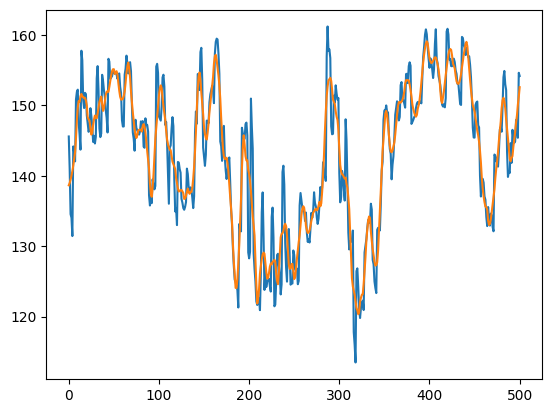

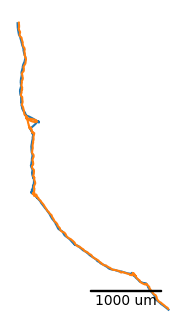

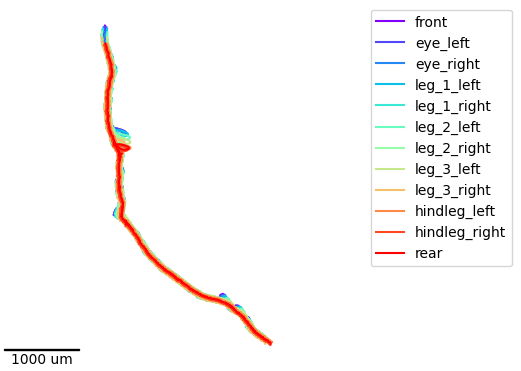

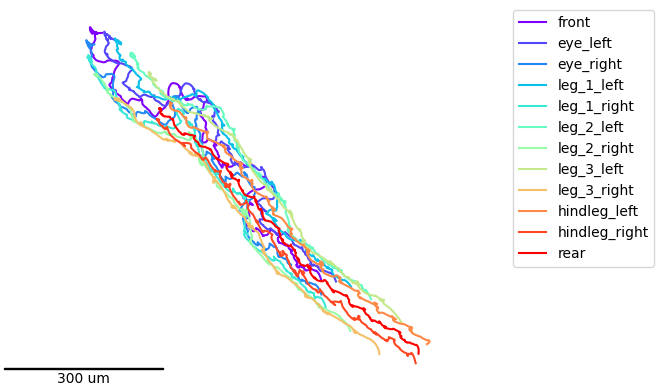

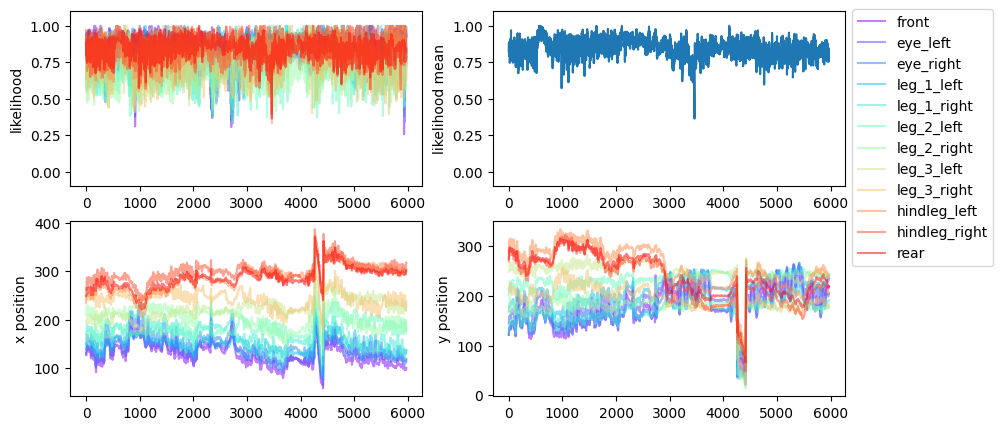

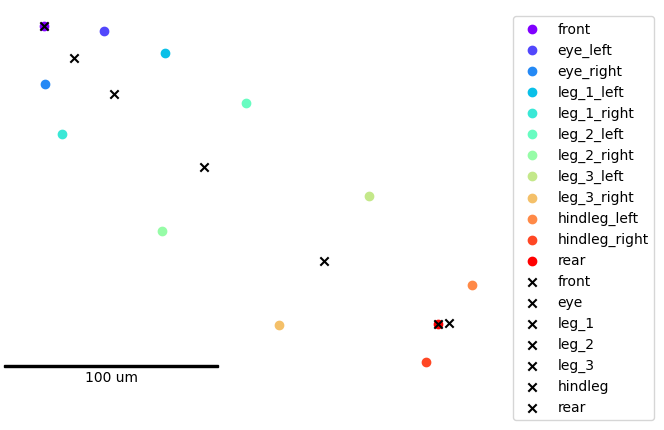

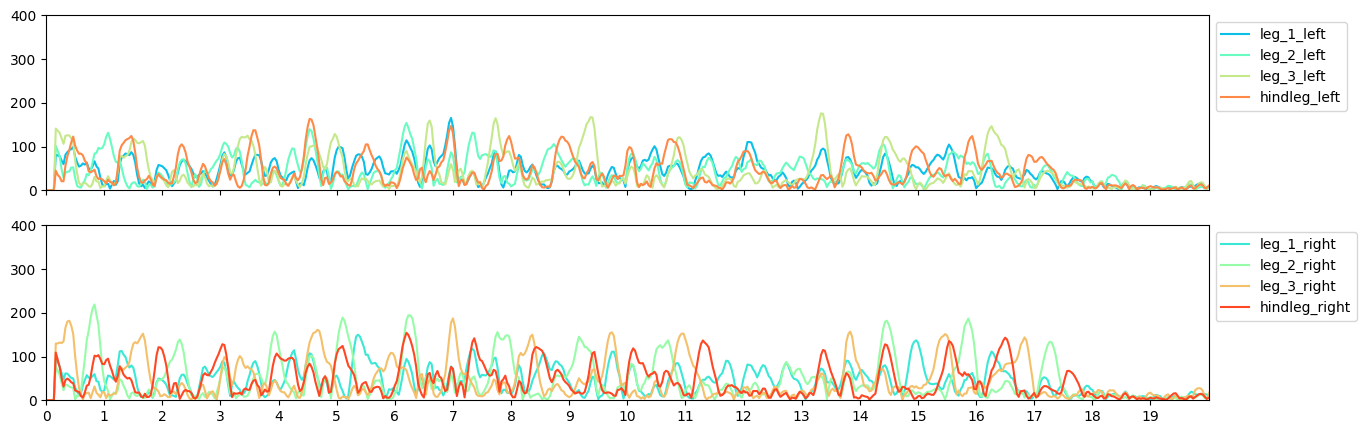

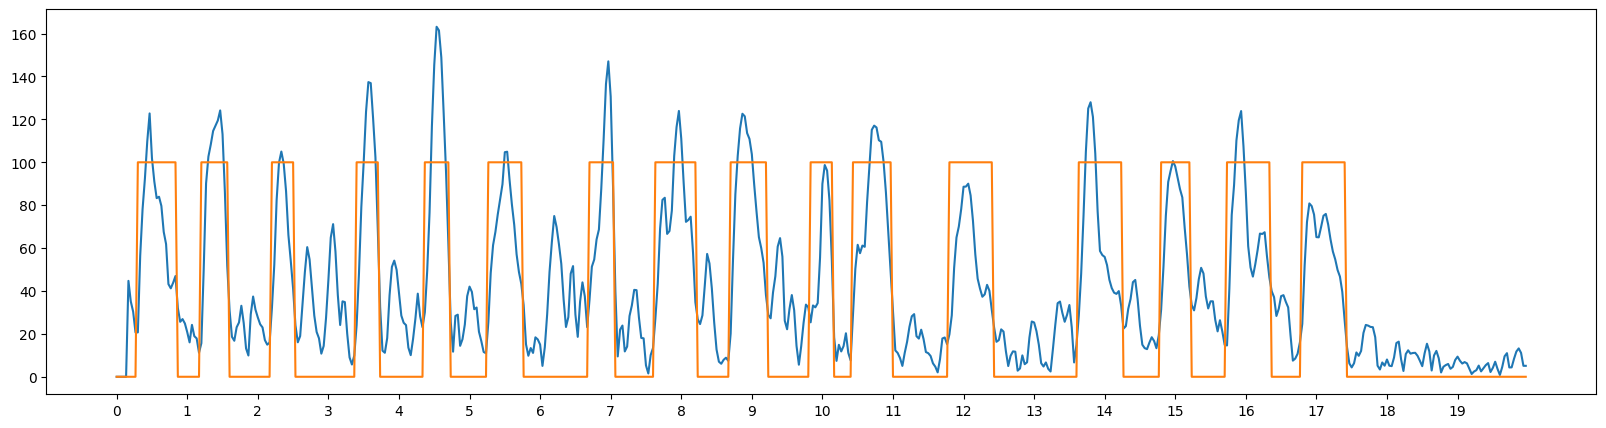

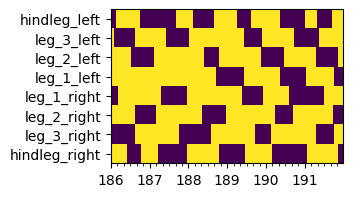

12MM_30FPS_2


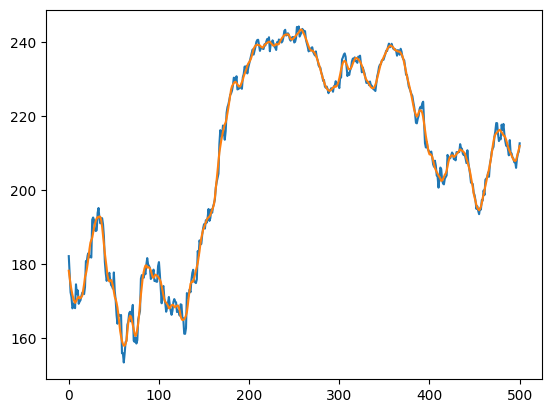

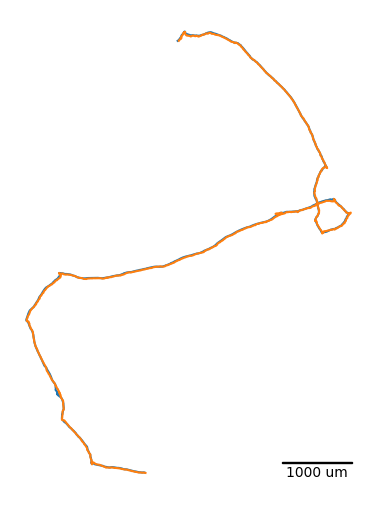

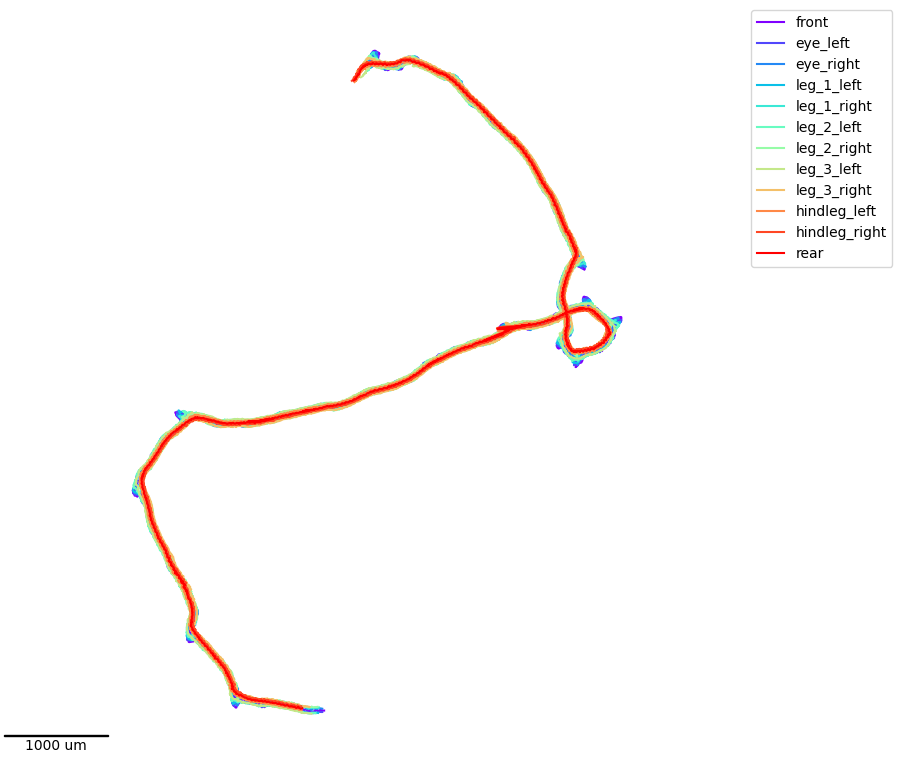

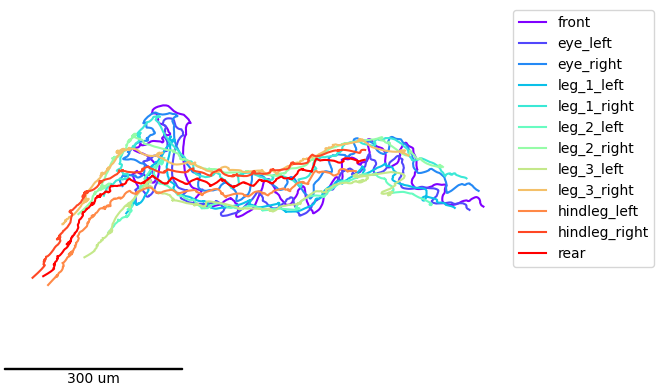

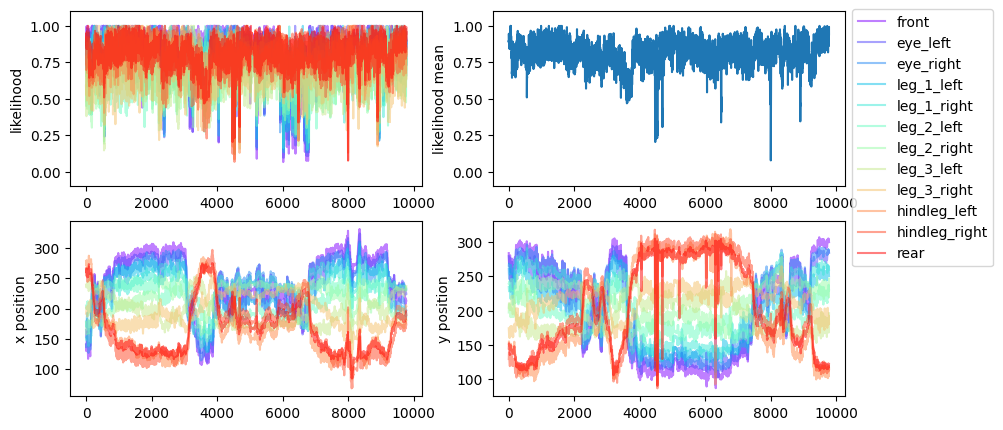

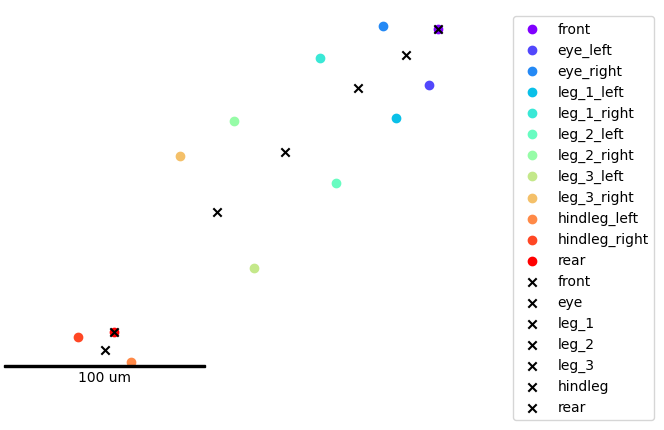

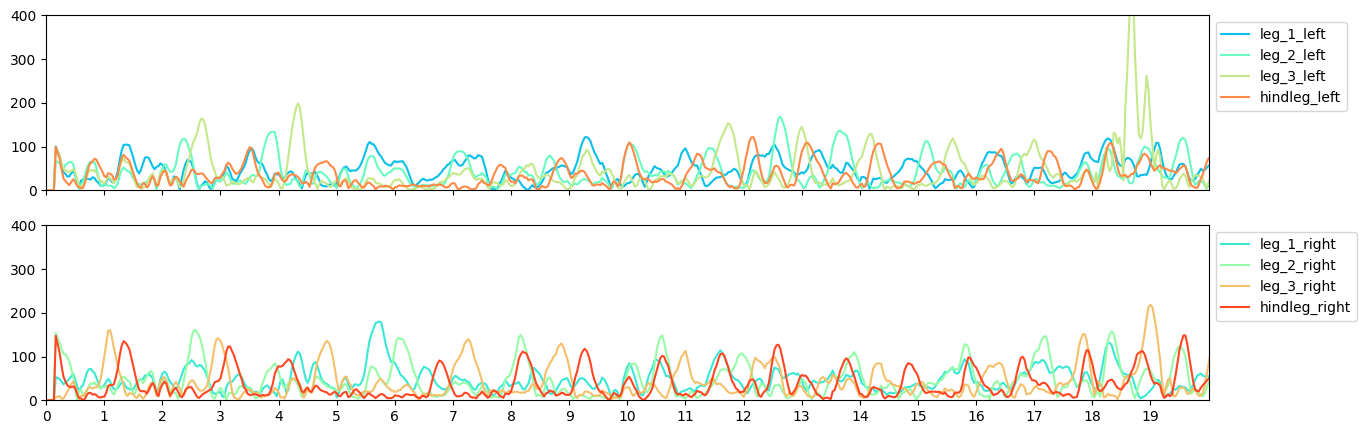

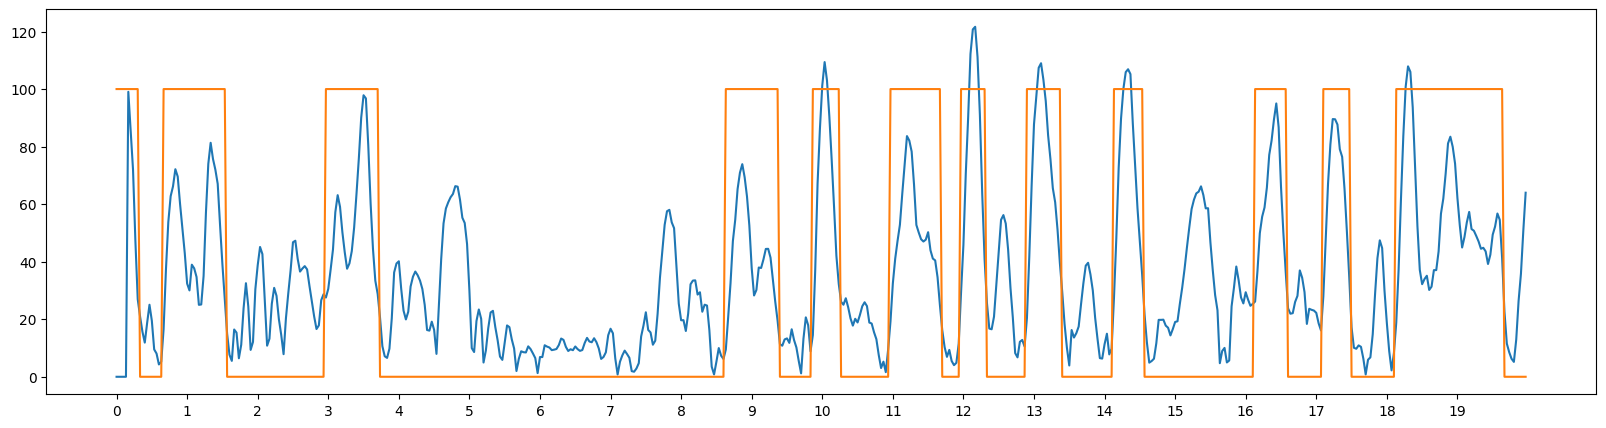

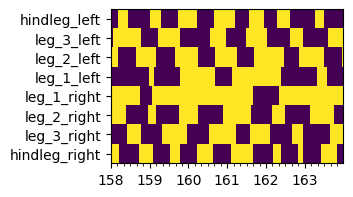

12MM_30FPS_offFOOD_3


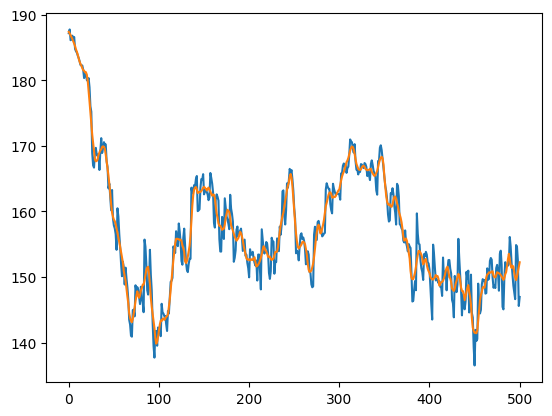

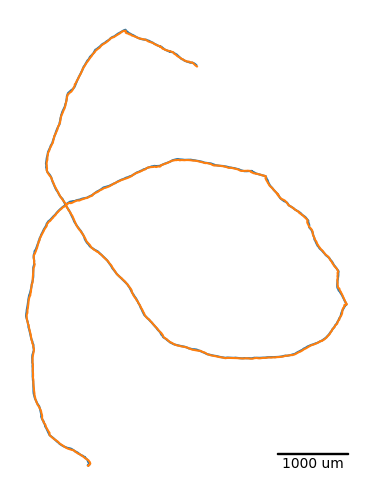

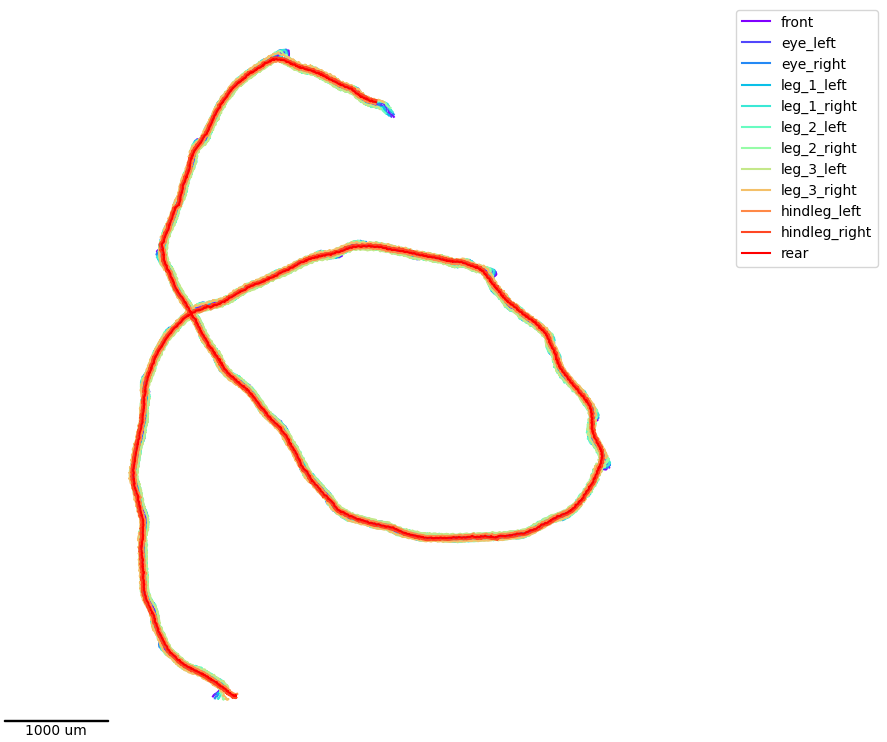

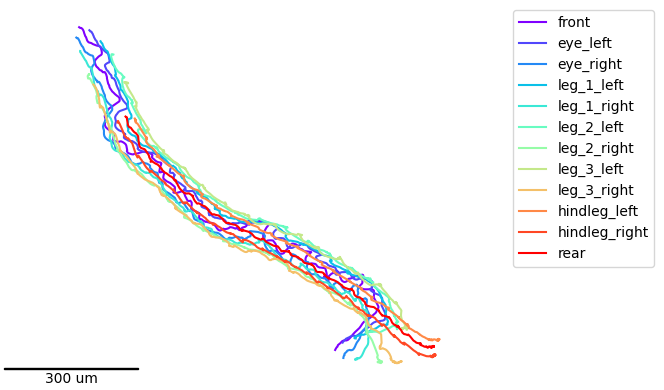

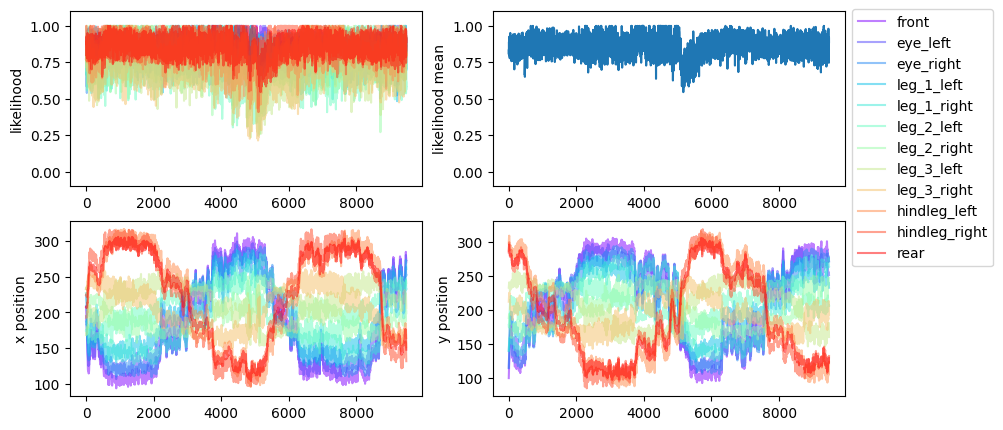

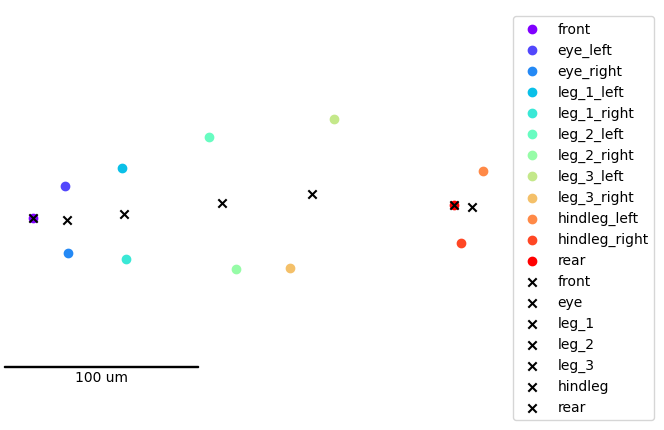

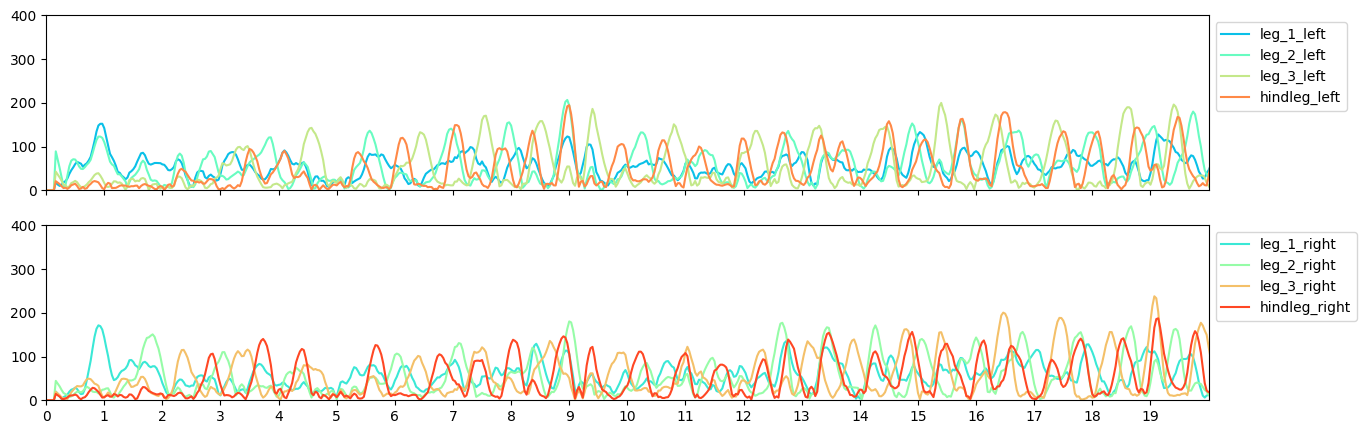

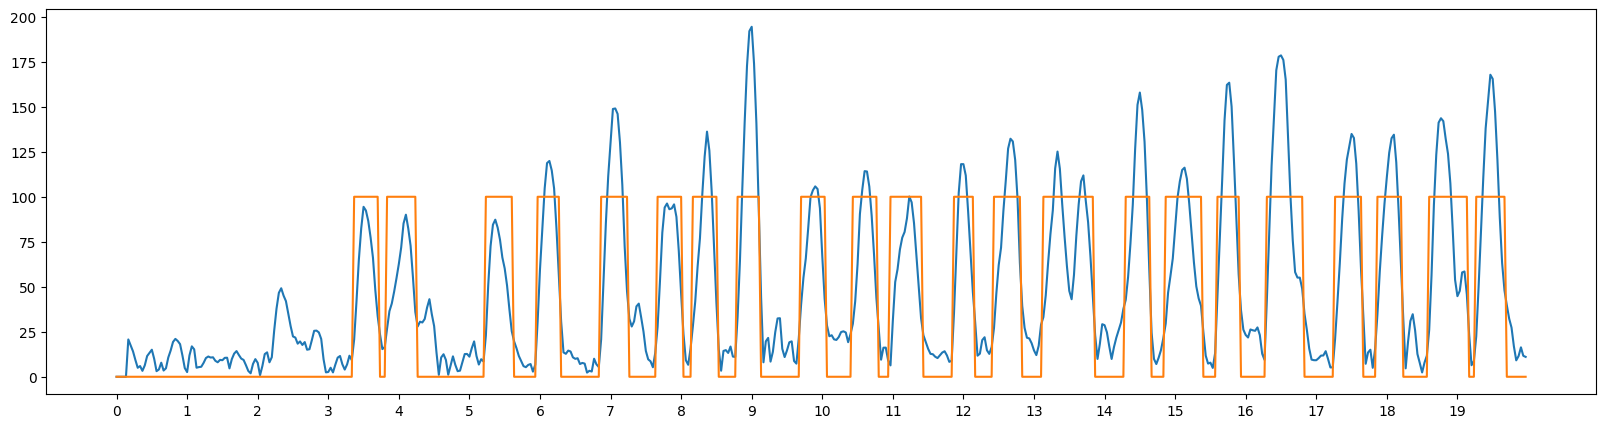

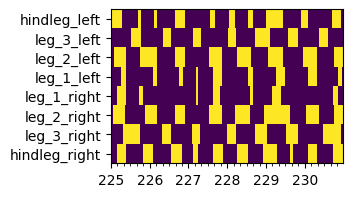

12MM_30FPS_offFOOD_4


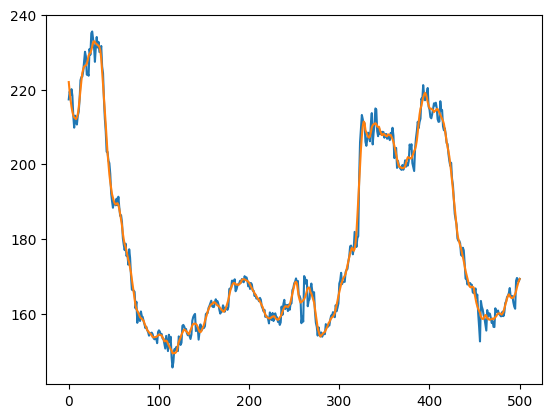

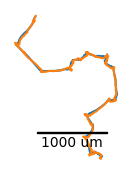

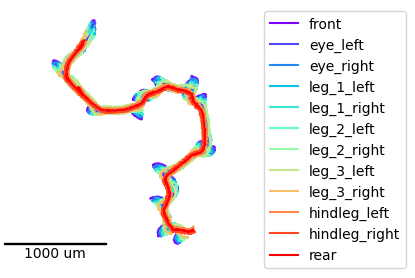

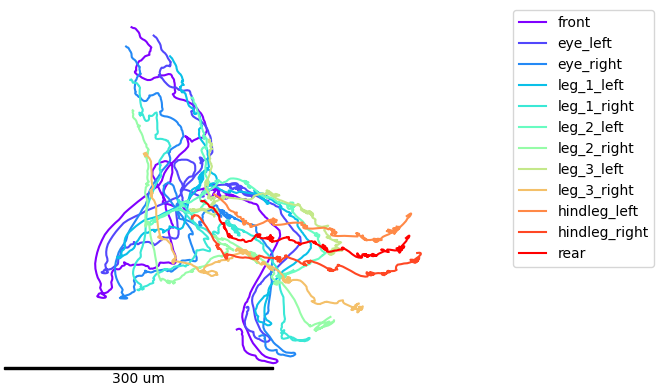

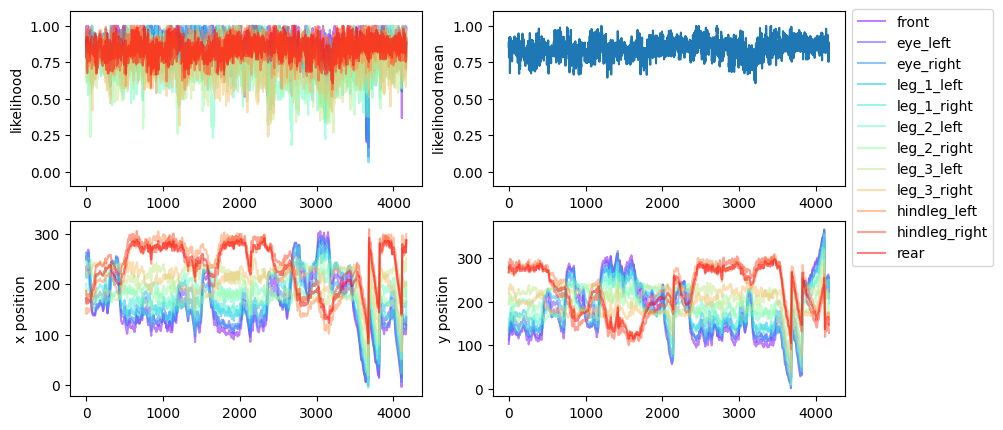

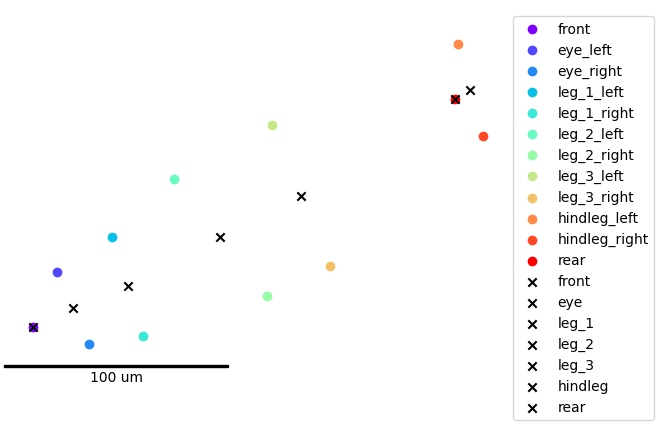

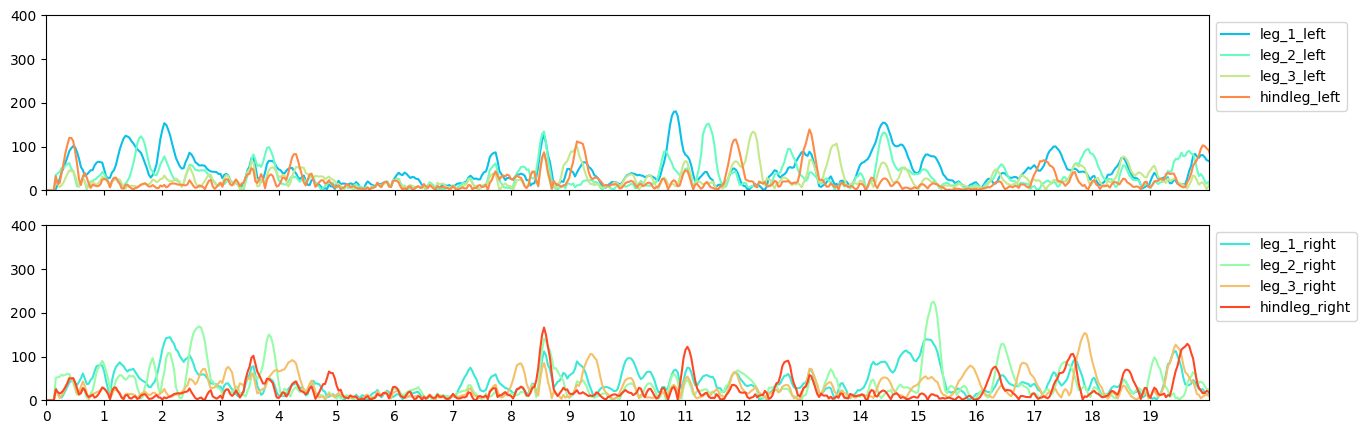

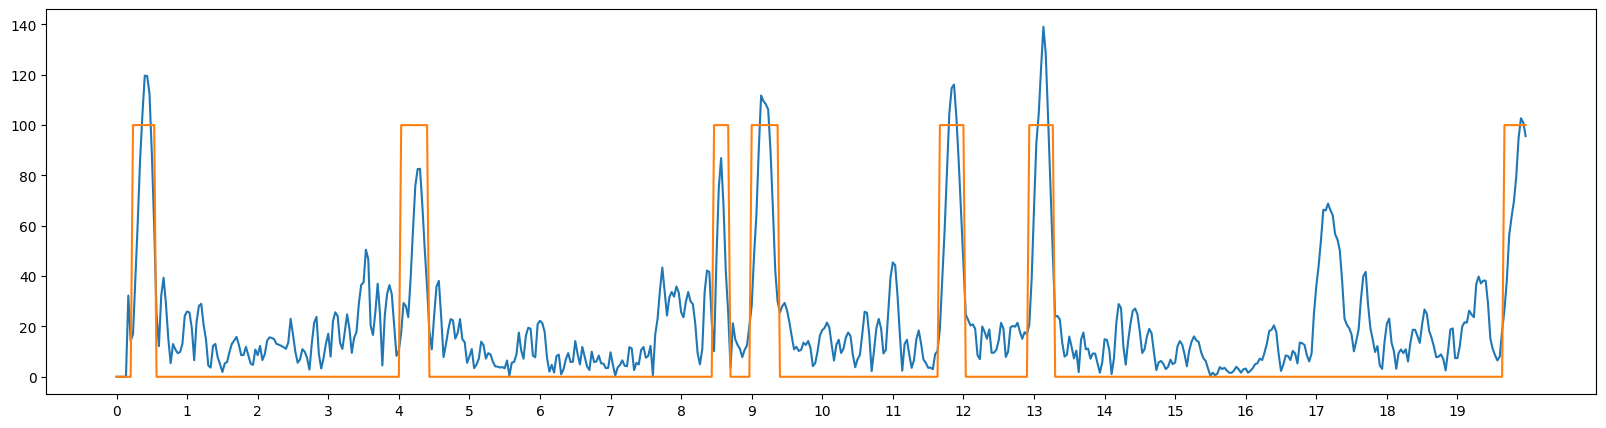

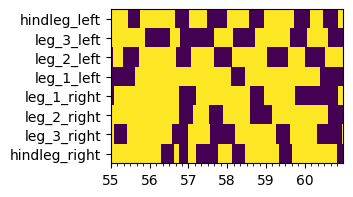

12MM_30FPS_offFOOD_5


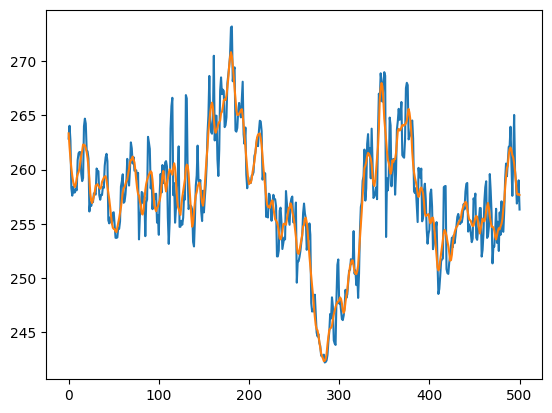

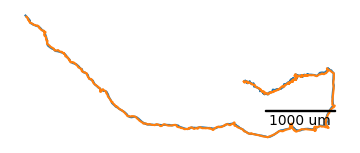

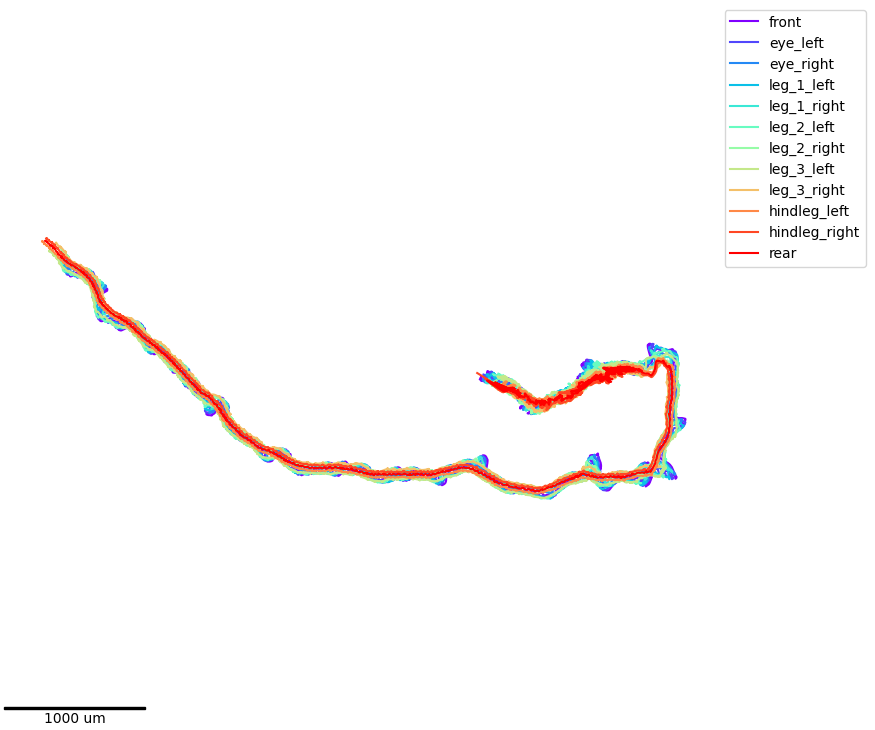

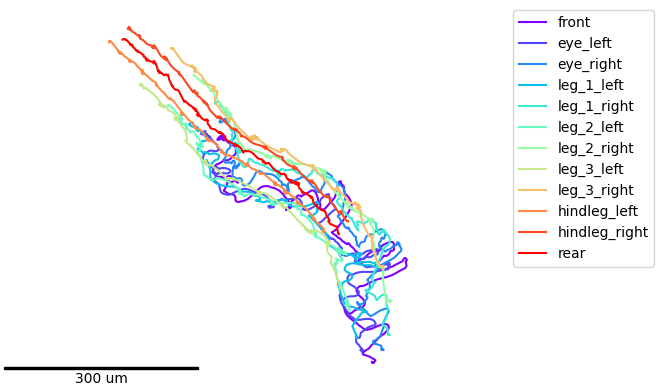

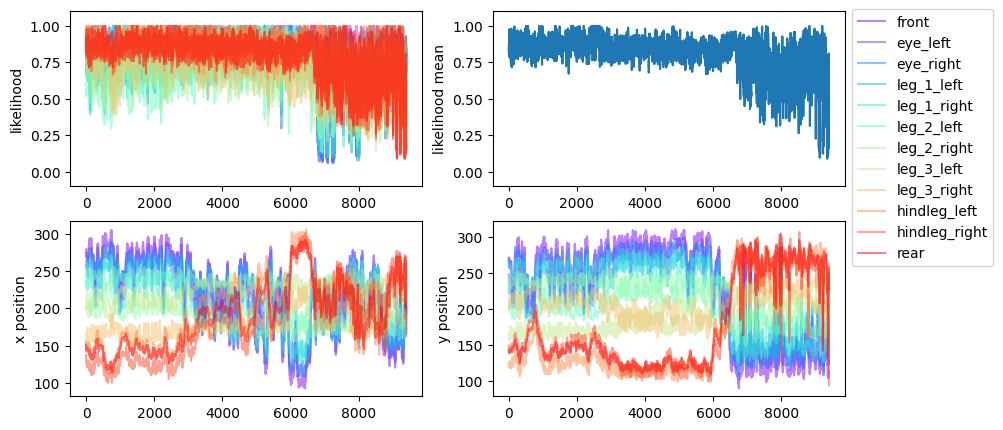

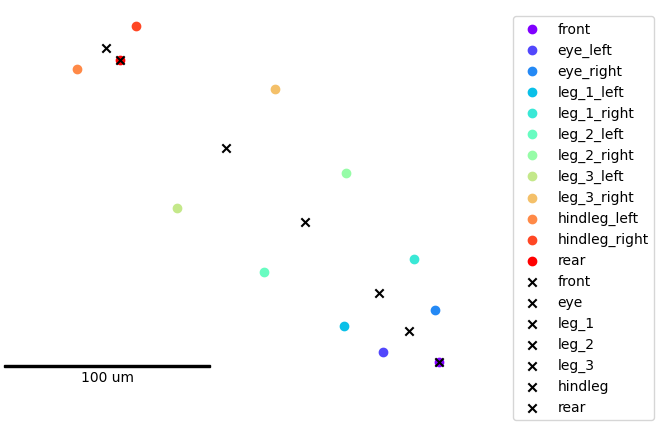

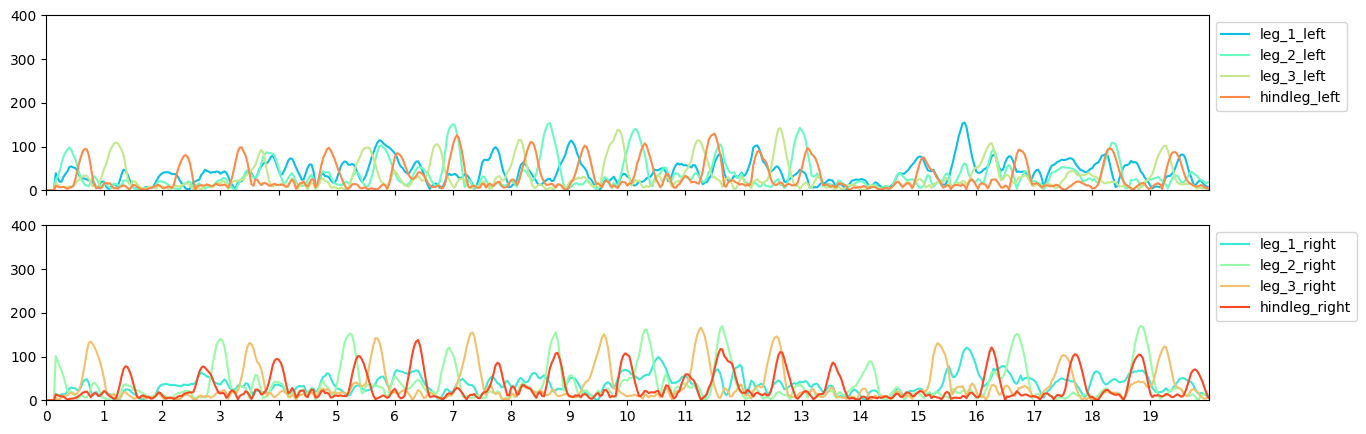

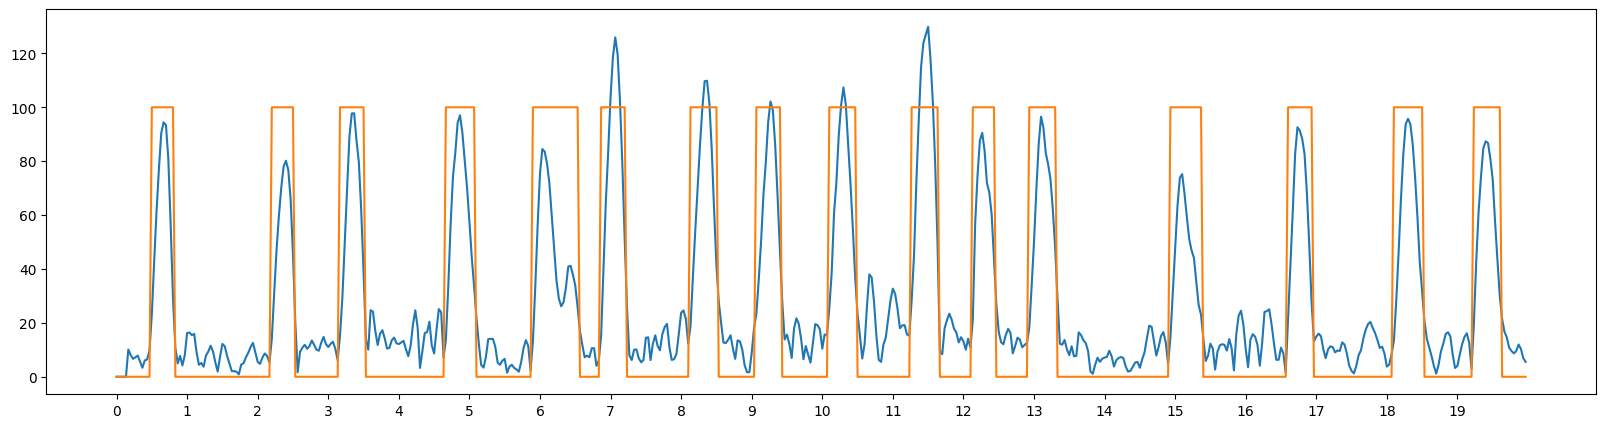

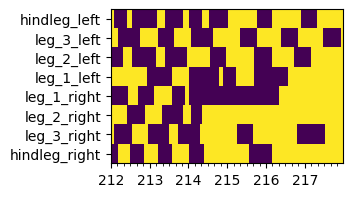

In [16]:
for i,id in enumerate(stage_files):
    print(id)
    stage_fn = stage_files[id]
    DLCfile_org = pd.read_csv(pose_files[id], header=[0,1,2])
    outfn = os.path.join(out_path,id)
    if not os.path.isdir(outfn):
        os.makedirs(outfn)
    DLCfile = DLCfile_org.copy()
    DLCfile = DLCfile.interpolate()

    # preprocessing

    # smooth DLCfile with savitzky golay
    DLCfile_org = DLCfile_org.interpolate()
    DLCfile = DLCfile_org.copy()
    DLCfile.loc[:,idx[:,:,['x','y']]] = savgol_filter(DLCfile_org.loc[:,idx[:,:,['x','y']]], 15, 2, axis=0)
    plt.plot(DLCfile_org.loc[:500, idx[:,'leg_1_left','x']])
    plt.plot(DLCfile.loc[:500, idx[:,'leg_1_left','x']])
    # Mean point between bodypart pairs
    mean_pairs = pd.DataFrame([])
    for p in pairs:
        bps = [bp for bp in bodyparts if p in bp]
        mean_p = DLCfile.loc[:,idx[:,bps,]].T.groupby(level=2).mean().T
        mean_p.columns = pd.MultiIndex.from_product([[p], mean_p.columns])
        mean_pairs = pd.concat([mean_pairs, mean_p], axis=1)
    # load stage and reorientate coordinates to stage 
    DLC, stage, centerline, matrix = tg.reformat_coordinatefile(stage_fn, DLCfile, mean_pairs)

    stage_Xrange = np.subtract(np.max(stage['X']), np.min(stage['X']))
    stage_Yrange = np.subtract(np.max(stage['Y']), np.min(stage['Y']))
    DLC_Xrange = np.subtract(np.max(DLC.loc[:,idx[:,:,'x']]), np.min(DLC.loc[:,idx[:,:,'x']]))
    DLC_Yrange = np.subtract(np.max(DLC.loc[:,idx[:,:,'x']]), np.min(DLC.loc[:,idx[:,:,'x']]))


    ### Tracks

    # CMS Tracks
    fig, ax = plt.subplots(figsize=(stage_Xrange, stage_Yrange))
    scale = 1000
    stage = stage.rolling(10, min_periods=1).mean()
    ax.plot(stage.loc[:,'Xstage'],stage.loc[:,'Ystage'], label='stage')
    ax.plot(stage.loc[:,'Xcms'],stage.loc[:,'Ycms'], label='aligned image')

    scalebar = AnchoredSizeBar(ax.transData,
                                scale, f'{scale} um', 'lower right', 
                                pad=1,
                                color='black',
                                frameon=False,
                                size_vertical=10,)
    ax.add_artist(scalebar)
    plt.axis('equal')
    plt.axis('off')
    plt.savefig(os.path.join(outfn, f'{id}_tracks.pdf'))
    plt.show()


    # Bodypart Tracks
    fig, ax = plt.subplots(figsize=(DLC_Xrange/500, DLC_Yrange/500))
    for bp in bodyparts:
        ax.plot(DLC.loc[:,idx[:,bp,'x']],
                DLC.loc[:,idx[:, bp,'y']], label = bp, color=bp_color_dict[bp], 
                )
    plt.legend(bbox_to_anchor=(1,1.02), loc='upper left')
    scale = 1000
    scalebar = AnchoredSizeBar(ax.transData,
                                scale, f'{scale} um', 'lower left', 
                                pad=-0.5,
                                color='black',
                                frameon=False,
                                size_vertical=10,)
    ax.add_artist(scalebar)
    plt.axis('equal')
    plt.axis('off')
    plt.savefig(os.path.join(outfn, f'{id}_tracks_limbs.pdf'), bbox_inches='tight')
    plt.show()
    
    # BodyPart Track Zoomed IN
    fig, ax = plt.subplots()
    for bp in bodyparts:
        ax.plot(DLC.loc[:20*fps,idx[:,bp,'x']],
                DLC.loc[:20*fps,idx[:, bp,'y']], label = bp, color=bp_color_dict[bp], 
                )
    plt.legend(bbox_to_anchor=(1,1.02), loc='upper left')
    scale = 300
    scalebar = AnchoredSizeBar(ax.transData,
                                scale, f'{scale} um', 'lower left', 
                                pad=-0.5,
                                color='black',
                                frameon=False,
                                size_vertical=2,)
    ax.add_artist(scalebar)
    plt.axis('equal')
    plt.axis('off')
    plt.savefig(os.path.join(outfn, f'{id}_tracks_limbs_first20s.pdf'), bbox_inches='tight')
    plt.show()

    ### DLC

    # likelood and and x y position
    fig, axs = plt.subplots(2,2, figsize=(10,5))
    axs = axs.flatten()
    for i, bp in enumerate(bodyparts):
        axs[0].plot(DLCfile.loc[:,idx[:,bp,'likelihood']], color=bp_color_dict[bp], alpha=.5)
        axs[2].plot(DLCfile.loc[:,idx[:,bp,'x']], color=bp_color_dict[bp], alpha=.5)
        axs[3].plot(DLCfile.loc[:,idx[:,bp,'y']], color=bp_color_dict[bp], alpha=.5, label=bp)
    axs[1].plot(DLCfile.loc[:,idx[:,bp,'likelihood']].mean(axis=1))
    for ax in axs[:2]:
        ax.set_ylim(-.1,1.1)
    axs[0].set_ylabel('likelihood')
    axs[1].set_ylabel('likelihood mean')
    axs[2].set_ylabel('x position')
    axs[3].set_ylabel('y position')
    plt.legend(loc='upper left', bbox_to_anchor=(1,2.25))
    plt.savefig(os.path.join(outfn, f'{id}_likelihood_position.pdf'), bbox_inches='tight')
    plt.show()

    # Bodypart first frame
    fig, ax = plt.subplots()
    for bp in bodyparts:
        ax.scatter(DLC.loc[0,idx[:, bp,'x']],
                DLC.loc[0,idx[:, bp,'y']], label = bp, color=bp_color_dict[bp])
    for p in pairs:
        ax.scatter(centerline.loc[0,idx[p,'x']],
                centerline.loc[0,idx[p,'y']], label = p, marker='x', color='k')
        
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    scale = 100
    scalebar = AnchoredSizeBar(ax.transData,
                                scale, f'{scale} um', 'lower left', 
                                pad=-0.5,
                                color='black',
                                frameon=False,
                                size_vertical=1,)
    ax.add_artist(scalebar)

    plt.axis('equal')
    plt.axis('off')
    plt.savefig(os.path.join(outfn, f'{id}_frame0.pdf'), bbox_inches='tight')
    plt.show()

    ### Analysis

    # calculate the velocity from aligned cms data
    stage['velocity'] = np.sqrt(stage['Xcms'].diff(periods=5)**2 + stage['Ycms'].diff(periods = 5)**2)/5*fps
    # calculate the velocity for each bodypart from aligned data
    DLCvelo = np.sqrt((DLC.loc[:,idx[:,:,'x']].diff(periods=5)**2).droplevel(2, axis=1) + (DLC.loc[:,idx[:,:,'y']].diff(periods=5)**2).droplevel(2, axis=1))/5*fps
    DLCvelo = DLCvelo.droplevel(0, axis=1)
    DLCvelo = DLCvelo.fillna(0)
    
    # velocity of all legs
    fig, axs = plt.subplots(2, 1, figsize=(15,5), sharex=True)
    for p in bp_pairs:
        axs[0].plot(DLCvelo[f'{p}_left'], label=f'{p}_left', c=bp_color_dict[f'{p}_left'])
        axs[1].plot(DLCvelo[f'{p}_right'], label=f'{p}_right', c=bp_color_dict[f'{p}_right'])
    for ax in axs:
        ax.set_ylim(0,400)
        ax.legend(bbox_to_anchor=(1,1), loc='upper left')
        ax.set_xlim(0*30,20*30)
        ax.set_xticks(np.arange(*ax.get_xlim(),30))
        ax.set_xticklabels(np.arange(*np.divide(ax.get_xlim(),30).astype(int),1))
    plt.savefig(os.path.join(outfn, f'{id}_legvelo.png'), bbox_inches='tight')
    plt.show()
    
    # detect swing bouts by peak detection on bodypart velocity
    swing_bouts = pd.DataFrame([]).reindex_like(DLCvelo)
    for bp in bodyparts:
        velo_peaks, velo_props = find_peaks(DLCvelo[bp], width=5, prominence=70, distance=1, height=70, rel_height=.75)
        peaks_bout = tg.ethogram_fromOnOff(velo_props['left_ips'], velo_props['right_ips'], arr_len=len(DLCvelo))
        peaks_bout = tg.mode_chunks(peaks_bout, max_range=5)
        swing_bouts[bp] =  peaks_bout.astype(bool) #fast_bout
    
    # example plot of hindleg for swing detection
    leg = 'hindleg_left'
    fig = plt.figure(figsize=(20,5))
    plt.plot(DLCvelo[leg][:600])
    plt.plot((swing_bouts[leg]*100)[:600])
    plt.xticks(np.arange(0, 600,30), (np.arange(0, 600,30)/30).astype(int));
    plt.savefig(os.path.join(outfn, f'{id}_{leg}_peak2swing.png'), bbox_inches='tight')
    plt.show()
    
    # Inverse swing detection to get stances
    stance = ~swing_bouts.astype(bool)
    stance = tg.mode_chunks(stance, max_range=5)

    # plot fraction from complete gait as example
    roi_stance = np.random.randint(0, stance.shape[0]-200, 1)
    if id in roi_defined:
        roi_stance = [roi_defined[id]]

    fig, axs = plt.subplots(len(roi_stance), figsize=(3,2*len(roi_stance)),)
    axs = axs if isinstance(axs, np.ndarray) else np.array([axs])
    for i, rng in enumerate(roi_stance):
        rng = (rng, rng+180)
        axs[i].imshow(stance[limbs_ord].astype(int).T,interpolation='none',rasterized=True)
        axs[i].set_yticks(range(len(limbs)))
        axs[i].set_yticklabels(limbs_ord)
        axs[i].axis('auto')
        axs[i].set_xlim(*rng)
        axs[i].set_xticks(np.arange(*rng,30))
        axs[i].set_xticks(np.arange(*rng,5), minor=True)
        axs[i].set_xticklabels(np.arange(*rng,30)//30)
    plt.savefig(os.path.join(outfn, f'{id}_hildebrand_example.pdf'), bbox_inches='tight')
    plt.show()

    # save
    DLCvelo.to_csv(os.path.join(outfn, f'{id}_DLCvelo.csv'))
    DLC.to_csv(os.path.join(outfn, f'{id}_DLC-coorinstage.csv'))
    stance.to_csv(os.path.join(outfn, f'{id}_stance.csv'))
    stage.to_csv(os.path.join(outfn, f'{id}_stage.csv'))